In [1]:
#LLAMANDO LIBRERIAS DE LENSTRONOMY
import numpy as np
import time
import corner
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import astropy.io.fits as pyfits


from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.output_plots as lens_plot

from lenstronomy.Util import constants

import lenstronomy.Util.param_util as param_util

from lenstronomy.ImSim.image_model import ImageModel

from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Sampling.parameters import Param

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
%matplotlib inline

!dir

 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 3288-2E83

 Directorio de C:\Users\Aristizabal.juan\OneDrive - Universidad de Los Andes\H0LICOW\Lenstronomy\Simulaciones\Data R0\GitHubRung0\rung0_lenstronomy

02/10/2019  11:25    <DIR>          .
02/10/2019  11:25    <DIR>          ..
19/09/2019  07:27    <DIR>          .git
02/10/2019  09:17    <DIR>          .ipynb_checkpoints
18/09/2019  18:56       (1.355.602) catalogue modelling.ipynb
18/09/2019  21:32            96.254 findingCoordinates.ipynb
28/07/2019  17:54            43.200 lens-image.fits
18/09/2019  18:56         (133.333) lens_equation.ipynb
28/12/2017  06:25            43.200 noise_map.fits
28/08/2019  15:14         (259.200) oversampled_PSF.fits
28/12/2017  06:25            43.200 psf.fits
18/09/2019  18:56              (19) README.md
18/09/2019  18:56           (5.264) Rung0
18/09/2019  19:52            25.211 Rung002.ipynb
18/09/2019  19:52         1.060.156 Rung003.ipynb
30/09/2019  0

In [2]:

import astropy
import numpy as np
from astropy.io import fits

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

background_rms = .05  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 99  # cutout pixel size
deltaPix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.8  # full width half max of PSF

In [3]:
# INTRODUCCION DE LOS DATOS DE MANERA MATRICIAL
# Mediante esta rutina ubicamos los lentes de acuerdo a la imagen
fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
fits_noise_filename = fits.util.get_testdata_filepath('noise_map.fits')
hdul = fits.open('lens-image.fits')
hdulnoise = fits.open('noise_map.fits')
image_data = hdul[0].data
noise_data = hdulnoise[0].data

# Modelo de la lente
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 8}
psf_class = PSF(**kwargs_psf)

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

data_class.update_data(image_data)
kwargs_data['image_data'] = image_data

data_class.update_data(noise_data)
kwargs_data['noise_map'] = noise_data


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


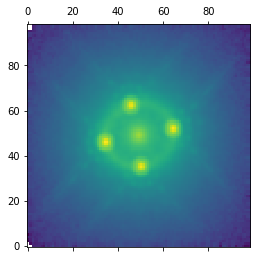

In [4]:
#Introduciendo datos artificiales, se realiza un comparativo entre la imagen real y una pseudo simulada.
# ES UNA IMAGEN PSEUDO SIMULADO 
from lenstronomy.LightModel.light_model import LightModel
lightModel = LightModel(lens_light_model_list)

kwargs_1 = {'amp': 200, 'R_sersic': 0.3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 0.0848, 'center_y': -1.09936}
kwargs_2 = {'amp': 200, 'R_sersic': 0.3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': -1.16496, 'center_y': -0.248}
kwargs_3 = {'amp': 200, 'R_sersic': 0.3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': 1.21336, 'center_y': 0.22688}
kwargs_4 = {'amp': 200, 'R_sersic': 0.3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': -0.27544, 'center_y': 1.05784}
kwargs_5 = {'amp': 100, 'R_sersic': 1, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x':0, 'center_y':0}
kwargs_light = [kwargs_1, kwargs_2, kwargs_3, kwargs_4, kwargs_5]

kwargs_numerics = {'supersampling_factor': 10}

from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens_light=kwargs_light)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_simulate = image_sim + bkg + poisson

#data_class.update_data(image_simulate)
#kwargs_data['image_data2'] = image_simulate

#plt.matshow(np.log10(image_simulate), origin='lower')
#plt.show()

plt.matshow(np.log10(image_data), origin='lower')
plt.show()

#plt.matshow(np.log10(noise_data), origin='lower')
#plt.show()

In [5]:
kwargs_model = {'lens_light_model_list': lens_light_model_list}
kwargs_constraints = {}
kwargs_numerics_galfit = {'supersampling_factor': 2}
kwargs_likelihood = {'check_bounds': True}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics_galfit]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [6]:

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# first Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.9, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': 0.085, 'center_y': -1.099})
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.001, 'center_y': 0.001})
kwargs_lower_lens_light.append({'e1': -1, 'e2': -1, 'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens_light.append({'e1': 1, 'e2': 1, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 1, 'center_y': 1})

# second Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.9, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': -1.165, 'center_y': -0.248})
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.001, 'center_y': 0.001})
kwargs_lower_lens_light.append({'e1': -1, 'e2': -1, 'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens_light.append({'e1': 1, 'e2': 1, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 2, 'center_y': 2})

# Third Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.9, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': 1.213, 'center_y': 0.226})
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.001, 'center_y': 0.001})
kwargs_lower_lens_light.append({'e1': -1, 'e2': -1, 'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': -1, 'center_y': -1})
kwargs_upper_lens_light.append({'e1': 1, 'e2': 1, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 2, 'center_y': 2})

# Fourt Sersic component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.9, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': -0.2754, 'center_y': 1.058})
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.001, 'center_y': 0.001})
kwargs_lower_lens_light.append({'e1': -1, 'e2': -1, 'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens_light.append({'e1': 1, 'e2': 1, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 2, 'center_y': 2})

# Hernquist component
fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.4, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.001, 'center_y': 0.001})
kwargs_lower_lens_light.append({'e1': -1, 'e2': -1, 'R_sersic': 0.01, 'n_sersic': 0.1, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens_light.append({'e1': 1, 'e2': 1, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 2, 'center_y': 2})


lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\lenstronomy-0.9.1-py3.7.egg\lenstronomy\ImSim\de_lens.py:16: RuntimeWarning: overflow encountered in multiply
  M = A.T.dot(np.multiply(C_D_inv, A.T).T)


200
max iteration reached! stoping
-1044.868669263869 reduced X^2 of best position
-5102093.712015472 logL
9766.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.4176519554729916, 'n_sersic': 7.999355085711679, 'e1': 0.33871570319998173, 'e2': 0.14437690160877725, 'center_x': 0.07432064690678636, 'center_y': -1.0562063290649348}, {'amp': 1, 'R_sersic': 0.029177353764628024, 'n_sersic': 2.768000735912078, 'e1': -0.837587993157465, 'e2': -0.5255685148673742, 'center_x': -1.1638437815268041, 'center_y': -0.25398654810346405}, {'amp': 1, 'R_sersic': 0.37808250925426595, 'n_sersic': 2.665968561537327, 'e1': -0.9845304578045176, 'e2': -0.08296761816927282, 'center_x': 1.2191043803079968, 'center_y': 0.22274834824326328}, {'amp': 1, 'R_sersic': 0.8257060196957517, 'n_sersic': 7.996220560212302, 'e1': 0.35255682635562346, 'e2': 0.14009215841938563, 'center_x': -0.26738076461344595, 'center_y': 0.991407999763681}, {'amp': 1, 'R_sersic': 0.01021565119917

reduced chi^2 =  1041.1373761892607


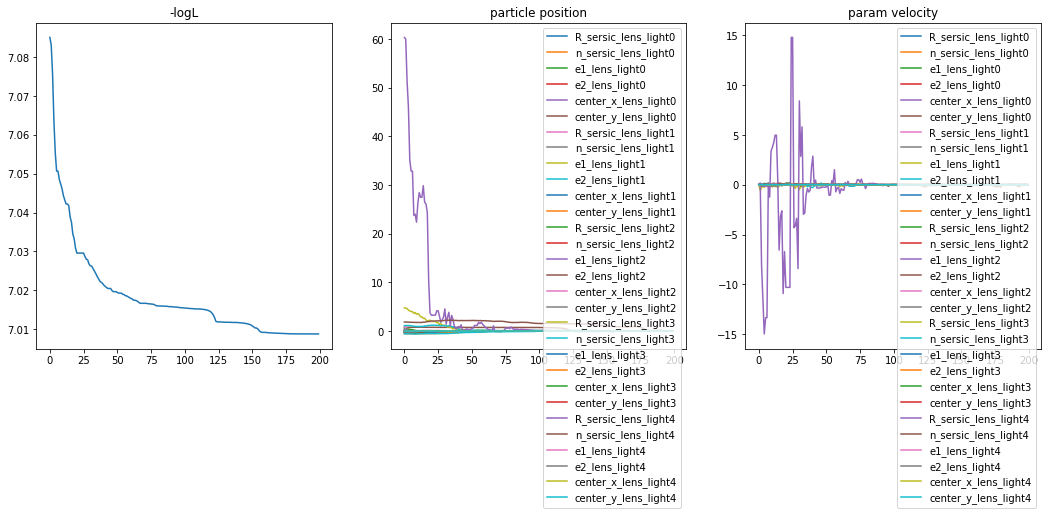

<Figure size 432x288 with 0 Axes>

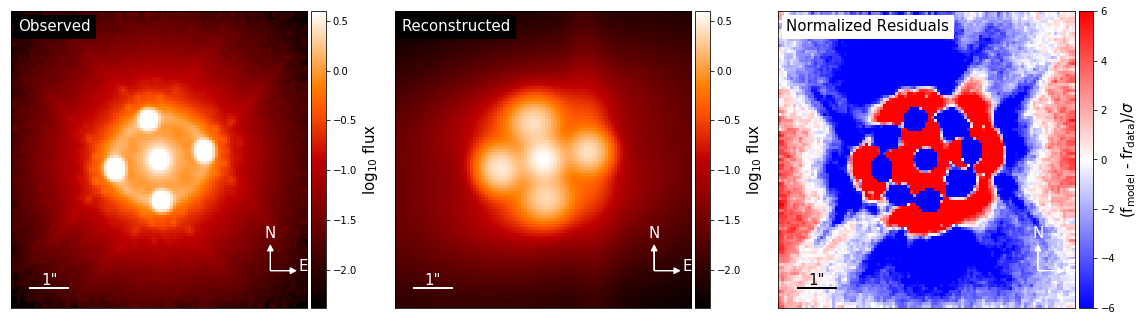

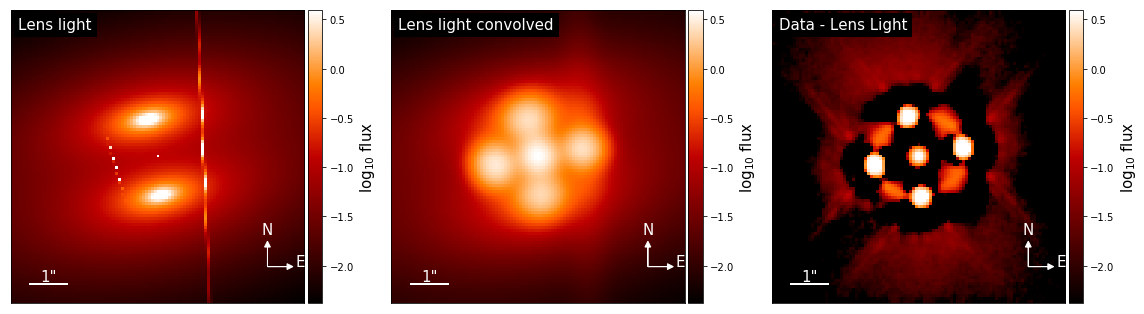

[{'amp': 27.198803468950587, 'R_sersic': 1.4176519554729916, 'n_sersic': 7.999355085711679, 'e1': 0.33871570319998173, 'e2': 0.14437690160877725, 'center_x': 0.07432064690678636, 'center_y': -1.0562063290649348}, {'amp': 16868172.8948548, 'R_sersic': 0.029177353764628024, 'n_sersic': 2.768000735912078, 'e1': -0.837587993157465, 'e2': -0.5255685148673742, 'center_x': -1.1638437815268041, 'center_y': -0.25398654810346405}, {'amp': 14625.786516920749, 'R_sersic': 0.37808250925426595, 'n_sersic': 2.665968561537327, 'e1': -0.9845304578045176, 'e2': -0.08296761816927282, 'center_x': 1.2191043803079968, 'center_y': 0.22274834824326328}, {'amp': 76.39424852356713, 'R_sersic': 0.8257060196957517, 'n_sersic': 7.996220560212302, 'e1': 0.35255682635562346, 'e2': 0.14009215841938563, 'center_x': -0.26738076461344595, 'center_y': 0.991407999763681}, {'amp': 5477857.848500584, 'R_sersic': 0.01021565119917301, 'n_sersic': 0.3412173498618448, 'e1': 0.0366787084338445, 'e2': 0.1554366471327625, 'center_

In [11]:
from lenstronomy.Plots.output_plots import ModelPlot
import lenstronomy.Plots.output_plots as out_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

for i in range(len(chain_list)):
    out_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1], text='Lens light convolved', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Lens Light', lens_light_add=True)
f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result['kwargs_lens_light'])

In [12]:
# VAMOS A REALIZAR LA CONSTRUCCION DEL LENTE USANDO SPEMD, SHEAR DEBIDO A QUE SABEMOS LOS RESULTADOS DEL RUNG0
# SIN EMBARGO ES NECESARIO REALIZARLOS HACIENDO LAS COMBINACIONES NECESARIAS

# Con la ayuda de IRAF deterinamos la ubicacion en pixeles, sabiendo que cada pixel son 0.08" para drizzzle images
# el centro esta ubicado en pixeles x = 49 y = 49
x_A = 0.0848
x_B = -1.16496
x_C = 1.21336
x_D = -0.27544

y_A = -1.09936
y_B = -0.248
y_C = 0.222688
y_D = 1.05784

x_source1 = [x_A, x_B, x_C, x_D]
y_source1 = [y_A, y_B, y_C, y_D]
# unidades en segundos de arco

# definimos valores de excentricidades completamente arbitrarios, incialmente
# pilas existen diferente tipos de excentricidades
# excentricidad para la lente, excentricidad de la fuente y excentricidad para el perfil de luz
# Determinamos phi de cada estrella, en teoria es el mismo para todos

# Definimos elipticidades e1, e2 de la masa de la lente
q = 0.88554837
phi= 1.82552
#Transformacion
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)

# Definimos redshift de la fuente y de la lente
z_source = 2.175
z_lens = 0.858

# Definimos algun tipo de cosmologia, aproximada
cosmo = FlatLambdaCDM(H0=80, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)

# Definimos lente mas basica tipo SPEMD, Incialmente sin perfil de luz, ni cizallamiento SHEAR.
lens_model_list = ['SPEMD']
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
lensEquationSolver = LensEquationSolver(lensModel=lensModel)
# Definimos caracteristicas basicas lente.
kwargs_spemd = {'theta_E':1.155297871,'gamma':2.044,'center_x':0,'center_y':0,'e1':e1,'e2':e2}
kwargs_lens = [kwargs_spemd]

# Debemos determinar la unicacion de la fuente, esto lo hacemos determinando Theta mediante inversion
# Al parecer escogemos en base a una unica lente, determinamos RA y DEC.
#---------------------------------------------------------------------------------------------------------------------------
# keep the imports and variables from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)
#-----------------------------------------------------------------------------------------------------------------------------

# Definimos ubicacion del lente. 
# Definimos una ubicacion del lente de acuerdo a las respuestas del RUNG0
x_source = 0.02
y_source = 0.001

# definimos todas las ubicaciones que determinamos midiendo los pixeles de la imagen
theta_raA, theta_decA = 0.08480, -1.09936
theta_raB, theta_decB = -1.16496, -0.24800
theta_raC, theta_decC = 1.21336, 0.22688
theta_raD, theta_decD = -0.27544, 1.05784

# Tenemos el siguiente problema debemos buscar la ubicacion de la lente en el plano coordenado apartir de las ubicaciones
# de las imagenes proyectadas en el plano de la lente y el observador
# es decir encontrar beta_ra, beta_dec a partir de theta_ra and theta_Dec

#beta_raA, beta_decA = lensModel.ray_shooting(theta_raA, theta_decA, kwargs_lens)
#beta_raB, beta_decB = lensModel.ray_shooting(theta_raB, theta_decB, kwargs_lens)
#beta_raC, beta_decC = lensModel.ray_shooting(theta_raC, theta_decC, kwargs_lens)
#beta_raD, beta_decD = lensModel.ray_shooting(theta_raD, theta_decD, kwargs_lens)

#x_source = beta_ra
#y_source = beta_dec

beta_ra = x_source
beta_dec = y_source

theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

#print(beta_raA, beta_raB, beta_raC, beta_raD)
#print(beta_decA, beta_decB, beta_decC, beta_decD)
print(beta_ra)
print(beta_dec)
print(theta_ra)
print(theta_dec)



0.02
0.001
[ 1.1656739  -1.09922869  0.03931187 -0.49610243]
[ 0.25654835 -0.35797804 -1.13425015  1.01229228]


image positions are:  [ 1.1656739  -1.09922869  0.03931187 -0.49610243] [ 0.25654835 -0.35797804 -1.13425015  1.01229228]
point source magnification:  [ 10.71076295  16.39514002 -12.84011509 -11.50517845]
source size in arcsec:  0.0013801985745829656
finite magnification:  [10.63124462 15.16720474 12.45982581 11.42266232]
time delays:  [-122.28503047 -115.02570585 -110.69881954 -109.2776313 ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


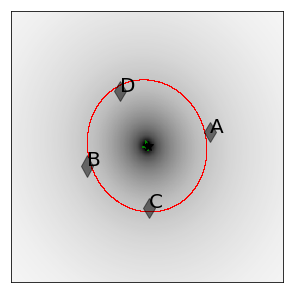

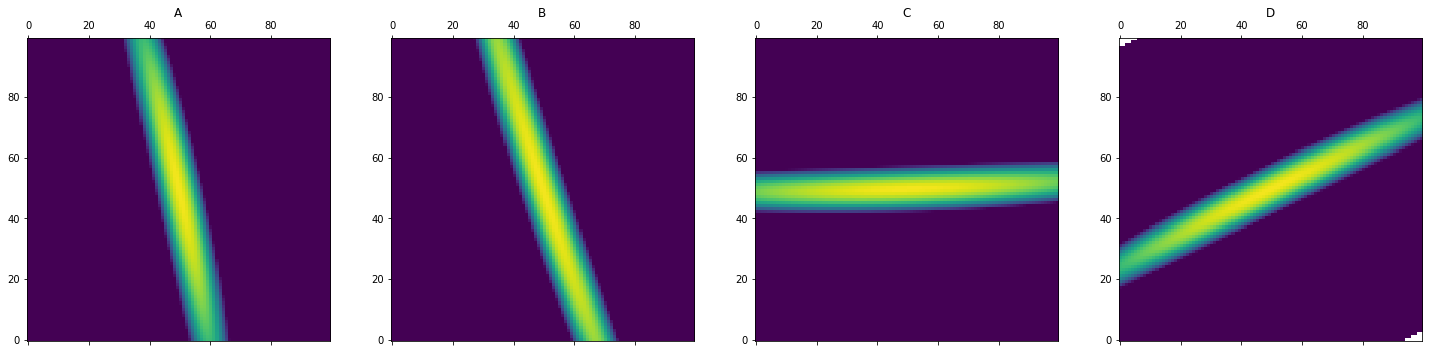

[ 1.1656739  -1.09922869  0.03931187 -0.49610243]
[ 0.25654835 -0.35797804 -1.13425015  1.01229228]


In [13]:
# DATOS PARA EL MODELAMIENTO DE LA LENTE, NO DEBEN MODIFICARSE, ESTA LINEA DE CODIGO NOS MUESTRA LA LENTE. 
# compute image positions and their (finite) magnifications

# we solve for the image position(s) of the provided source position and lens model
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_source, 
                                                             sourcePos_y=y_source)
print('image positions are: ', x_img, y_img)
# the infinitesimal magnification at the position of the images is:
mag_inf = lensModel.magnification(x_img, y_img, kwargs_lens)
print('point source magnification: ', mag_inf)


# we chose a finite source size of the emitting 'point source' region
source_size_pc = 10. # Gaussian source size in units of parsec
# we convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.D_s
source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec
print('source size in arcsec: ', source_size_arcsec)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.08  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

# and here are the finite magnifications computed
mag_finite = lensModelExtensions.magnification_finite(x_pos=x_img, y_pos=y_img, kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
print('finite magnification: ', mag_finite)



# here are the predicted time delays in units of days
t_days = lensModel.arrival_time(x_img, y_img, kwargs_lens)
print('time delays: ', t_days)

# here we plot the lens model, including (optional) the caustics and critical curves
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True)
f.show()


# here we plot the finite sources as seen at the different image positions
f, axes = plt.subplots(1, len(x_img), figsize=(5*5, 5*len(x_img)), sharex=False, sharey=False)
label_list = ['A', 'B', 'C', 'D']
for i in range(len(x_img)):
    image = lensModelExtensions.zoom_source(x_pos=x_img[i], y_pos=y_img[i], kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
    ax = axes[i]
    ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
    ax.set_title(label_list[i])
plt.show()

print(theta_ra)
print(theta_dec)

In [14]:
#SUBIENDO LOS DATOS MEDIANTE MATRIZ
from astropy.utils.data import download_file
from astropy.io import fits

#path = 'code1/f160w-seed3/'

im_oversample = []
im_lens = []
im_psf = []
for i in range(1,9):
    im_oversample.append(fits.getdata("lens-image.fits"))
    im_lens.append(fits.getdata("lens-image.fits"))
    im_psf.append(fits.getdata("noise_map.fits"))
#plt.imshow(test[0].data,cmap = 'gray')
    

im_oversample = np.array(im_oversample)    
im_lens = np.array(im_lens)
im_psf = np.array(im_psf)